In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
rawdata1 = pd.read_excel("./dataset/tourdata2017_1.xlsx")
rawdata2 = pd.read_excel("./dataset/tourdata2017_2.xlsx")
rawdata3 = pd.read_excel("./dataset/tourdata2017_3.xlsx")

# 분석 데이터 정제

## 1. 불필요한 데이터 및 컬럼 제거

In [3]:
# 컬럼명 통일 (공백제거, 컬럼명 소문자 )

rawdata1.rename(columns=lambda x: x.strip().lower(), inplace=True)
rawdata2.rename(columns=lambda x: x.strip().lower(), inplace=True)
rawdata3.rename(columns=lambda x: x.strip().lower(), inplace=True)

### 1-1. 응답자 특성 데이터

In [4]:
# 나이를 세대별로 구분하기 위해 새로운 컬럼 생성

rawdata1["age_group"] = np.where(rawdata1["age"]>0, (((rawdata1["age"]/10).astype(int))*10) , 0)

In [5]:
# 응답자 20대 추출

rawdata1 = rawdata1[rawdata1.age_group==20]

In [6]:
# 필요한 컬럼만 선택해서 보기
# 분석에 불필요한 컬럼을 제거

rawdata1 = rawdata1.drop(['age_group','sr_type','ara_size', 'school1','school2','occ0','occ2','marry','fac','inc1_1','inc2_1',
                          'wt'], axis = 1)

### 1-2. 단위여행 베이스

In [7]:
# m_id 빈 값 지우기
# m_id 값이 null이면 다른 컬럼의 value도 null이기 때문에 해당 열을 삭제

rawdata2 = rawdata2.dropna(subset=["m_id"])

In [8]:
#국내여행자만 선택해서 보기

rawdata2 = rawdata2[rawdata2["type1"] == 1]

In [9]:
# 여행 주 목적 : 1.여가/위락/휴가 2.건강/치료 3.종교/성지순례 데이터가 존재
#  2.건강/치료 3.종교/성지순례의 경우 데이터가 소수이며 분석 목적과 무관하여 제거

rawdata2 = rawdata2[rawdata2["q3"].astype(int) == 1]

In [10]:
# 총지출비용 컬럼이 null값인 데이터를 삭제

rawdata2 = rawdata2.dropna(subset=["q7"])

In [11]:
# 필요한 컬럼만 선택해서 보기
# 분석에 불필요한 컬럼을 제거

rawdata2 = rawdata2.drop(['m_id','type1','type2','q2_a','q2_a_1','q2_a_2','q2_b','q2_b_1','q2_b_1','q2_b_2','q2_c_1','q2_1_1',
                          'q2_1_2','q2_1_3','q2_1_4','q2_1_5','q3', 'q4_1_a','q4_1_b','q5_1','q5_2_1','q5_2_2','q5_2_3','q5_2_4',
                          'q5_2_5','q5_2_6','q7_1','q7_3_1','q7_3_2','q7_3_3','q7_3_4','q7_3_5','q7_3_6','q7_3_7','q7_3_8','q7_3_9',
                          'q7_3_10','q9_1','q9_1_1','q9_1_2','q9_1_3','q9_1_4','q9_1_5','q9_2','wt'], axis = 1)

### 1-3. 방문지 베이스

In [12]:
# m_id 빈 값 지우기
# m_id 값이 null이면 다른 컬럼의 value도 null이기 때문에 해당 열을 삭제

rawdata3 = rawdata3.dropna(subset=["m_id"])

In [13]:
#국내여행자만 선택해서 보기

rawdata3 = rawdata3[rawdata3["type1"] == 1]

In [14]:
# 필요한 컬럼만 선택해서 보기
# 분석에 불필요한 컬럼을 제거

rawdata3 = rawdata3.drop(['m_id','type1','type2','q6_1_1','q6_1_2','q6_1_3','q6_1_4','q6_1_5','q6_1_6','q6_1_7','q6_1_8',
                          'q6_5_1a','q6_5_2a','q6_5_3a','q6_5_4a','q6_5_5a','q6_5_6a','q6_5_7a','q6_5_8a','q6_5_9a','q6_5_10a',
                          'q6_5_11a','q6_5_12a','q6_5_13a','q7_2','q6_2','wt'], axis = 1)

### 1-4. 1차 join = 단위여행 + 방문지

In [15]:
# 1차 join = 같은 응답자의 단위여행 데이터와, 방문지 데이터를 합친다.
# hid,pid,month가 같으면 해당데이터는 동일인물임

joinKey = ["hid","pid","month"]

In [16]:
firstmerge = pd.merge(rawdata2, rawdata3, left_on=joinKey, right_on=joinKey, how="left")

### 1-5. 2차 join = 응답자 + 1차 join

In [17]:
# 2차 join 데이터 = 같은 응답자의 응답자 정보와 1차 join 데이터를 합친다.
# hid,pid가 같으면 해당데이터는 동일인물임

joinKey2 = ["hid","pid"]

In [18]:
secondmerge = pd.merge(rawdata1, firstmerge, left_on=joinKey2, right_on=joinKey2, how="left")

In [19]:
result00 = secondmerge.reset_index(drop = True)

## 2. 새로운 컬럼 생성

### 2-1. 직업 기준 생성

In [20]:
# 직업을 분류를 명확히하기 위해 대학생,직장인,무직,군인,무응답으로 재설정

jobCodeList = []

for i in range(0,len(result00)):
    jobCode = 123
    job = result00["occ1"][i]
    
    if ((job == 14) | (job == 15)):
        #대학생
        jobCode = 1
    elif job < 10:
        #직장인
        jobCode = 2
    elif job == 16:
        #무직
        jobCode = 3
    elif job == 10:
        #군인
        jobCode = 4
    else:
        jobCode = 999
    jobCodeList.append(jobCode)

In [21]:
# 컬럼이름을 지정후 기존 데이터에 추가

columnName = "job_group"
tempDF = pd.DataFrame(jobCodeList, columns=[columnName])
result01 = pd.concat([result00, tempDF], axis=1)

### 2-2. 만족도 기준 생성

In [22]:
# 항목별 만족도 컬럼이 null값인 데이터를 삭제
# 기존 만족도 데이터는 단편적이며 데이터를 분류하는데 어려움이 있기 때문에 새로운 만족도 기준을 생성

result01 = result01.dropna(subset=["q10_1"]).reset_index(drop = True)

In [23]:
# 항목별 만족도에서 9.경험해보지 못함 -> 0으로 바꿈

result01.loc[:,"q10_1":"q10_12"] = np.where(result01.loc[:,"q10_1":"q10_12"] == 9,0,result01.loc[:,"q10_1":"q10_12"])

In [24]:
# 항복별 만족도의 평균을 구한후 소수점 반올림후 2배하여 새로운 기준을 생성

tempList = []

for i in range(0,len(result01)):
    zeroCount = 0
    for j in result01.loc[i,"q10_1":"q10_12"]:
        if j==0:
            zeroCount += 1
    
    # 항목별 만족도, 전반적 만족도, 재방문의향, 추천의향에 가중치를 설정
    tempList.append(
     (round((math.pow((sum(result01.loc[i,"q10_1":"q10_12"]) / (12-zeroCount)), 2)) * 10) / 10) * 1.2
     + (math.pow((result01.loc[i,"q6_7"]), 2) * 1.6)
     + (math.pow((result01.loc[i,"q6_8"]), 2) * 0.8)
     + (math.pow((result01.loc[i,"q6_9"]), 2) * 0.4))

In [25]:
# 컬럼이름을 지정후 기존 데이터에 추가

colName = "q10_grade"
tempDF = pd.DataFrame(tempList, columns=[colName])
result02 = pd.concat([result01, tempDF], axis=1)

### 2-3. 일별 지출비용 등급

In [26]:
# 지출비용을 이용한 분류를 명확히 하기 위해 지출비용을 5단계로 설정
# 1 : 3만원 이하 
# 2 : 6만원 이하
# 3 : 10만원 이하
# 4 : 20만원 이하
# 5 : 20만원 초과

tempList = []

for i in range(0,len(result02)):
    q7 = result02.loc[i,"q7"]
    day = result02.loc[i,"q2_c_2"]
    temp = q7 / day
    
    if (temp <= 30000):
        grade = 1
    elif (temp <= 60000):
        grade = 2
    elif (temp <= 100000):
        grade = 3
    elif (temp <= 200000):
        grade = 4
    elif (temp > 200000):
        grade = 5
    
    tempList.append(grade)

In [27]:
# 컬럼이름을 지정후 기존 데이터에 추가

colName = "q7_grade"
tempDF = pd.DataFrame(tempList, columns=[colName])
result03 = pd.concat([result02, tempDF], axis=1)

### 2-4. 여행 정보 주요 획득지 컬럼 재정의

In [28]:
#  q4_a,q4_b 두개 컬럼에 value 값이 1~11로 존재하던 정보를 다른 컬럼과 동일하게 재정의
# 해당 value 값의 컬럼을 새로 만들어서 해당 컬럼을 이용여부를 체크
# ex) q4_1(여행사) value : 1 or null
# ex) q4_4(인터넷) value : 4 or null

tempList = [[],[],[],[],[],[],[],[],[],[],[]]

# 데이터의 길이만큼 인덱스로 반복 접근
for i in range(0, len(result03["q4_a"])):
    tempTarget = None
    tempTarget2 = None

    # null 값 체크후 list에 데이터 추가
    if (result03["q4_a"][i].astype(int) != -2147483648):
        tempTarget = result01["q4_a"][i].astype(int)
        tempList[tempTarget - 1].append(tempTarget)
        
   # null 값 체크, q4_a 컬럼과 q4_b 컬럼 데이터의 중복여부 체크후  list에 데이터 추가
    if (result03["q4_b"][i].astype(int) != -2147483648):
        tempTarget2 = result01["q4_b"][i].astype(int)
        if (tempTarget != tempTarget2):
            tempList[tempTarget2 - 1].append(tempTarget2)
        elif (tempTarget == tempTarget2):
            tempTarget2 = None
    
    #  q4_a 컬럼과 q4_b 컬럼 데이터 이외에는 list에 null값 추가
    for j in range(0, 11):
        if ((tempTarget != j+1) & (tempTarget2 != j+1)):
            tempList[j].append(None)

In [29]:
# q4_1. 여행사
# q4_2. 가족/친지
# q4_3. 친구/동료
# q4_4. 인터넷
# q4_5. 관광 안내 서적
# q4_6. 기사 및 방송 프로그램
# q4_7. 광고
# q4_8. 과거 방문경험
# q4_9, 스마트 폰 등 모바일 앱(어플)
# q4_10. 기타
# q4_11. 없음

tempDic = {
    "q4_1" : tempList[0],
    "q4_2" : tempList[1],
    "q4_3" : tempList[2],
    "q4_4" : tempList[3],
    "q4_5" : tempList[4],
    "q4_6" : tempList[5],
    "q4_7" : tempList[6],
    "q4_8" : tempList[7],
    "q4_9" : tempList[8],
    "q4_10" : tempList[9],
    "q4_11" : tempList[10]
}

In [30]:
# 기존 데이터에 추가

dicDF = pd.DataFrame(tempDic)
result04 = pd.concat([result03, dicDF], axis=1)

### 2-5. 여행지 선택 이유 컬럼 재정의

In [31]:
#  q6_3_a,q6_3_b,q6_3_c 세개 컬럼에 value 값이 1~15로 존재하던 정보를 다른 컬럼과 동일하게 재정의
# 해당 value 값의 컬럼을 새로 만들어서 해당 컬럼을 이용여부를 체크
# ex) q6_3_1(여행지 지명도) value : 1 or null
# ex) q6_3_12(경험자의 추천) value : 12 or null

tempList = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

# 데이터의 길이만큼 인덱스로 반복 접근
for i in range(0, len(result04["q6_3_a"])):
    tempTarget = None
    tempTarget2 = None
    tempTarget3 = None

    # null 값 체크후 list에 데이터 추가
    if (result04["q6_3_a"][i] .astype(int) != -2147483648):
        tempTarget = result01["q6_3_a"][i].astype(int)
        tempList[tempTarget - 1].append(tempTarget)
        
    # null 값 체크, q6_3_a 컬럼과 q6_3_b 컬럼 데이터의 중복여부 체크후  list에 데이터 추가
    if (result04["q6_3_b"][i] .astype(int) != -2147483648):
        tempTarget2 = result01["q6_3_b"][i].astype(int)
        if (tempTarget != tempTarget2):
            tempList[tempTarget2 - 1].append(tempTarget2)
        else:
            tempTarget2 = None
            
    # null 값 체크, q6_3_a~c 컬럼 데이터의 중복여부 체크후  list에 데이터 추가
    if (result04["q6_3_c"][i] .astype(int) != -2147483648):
        tempTarget3 = result01["q6_3_c"][i].astype(int)
        if ((tempTarget != tempTarget3) & (tempTarget2 != tempTarget3)):
            tempList[tempTarget3 - 1].append(tempTarget3)
        else:
            tempTarget2 = None
    
    #  q6_3_a~c 컬럼 데이터 이외에는 list에 null값 추가
    for j in range(0, 15):
        if ((tempTarget != j+1) & (tempTarget2 != j+1) & (tempTarget3 != j+1)):
            tempList[j].append(None)

In [32]:
# q6_3_1. 여행지 지명도
# q6_3_2. 볼거리 제공
# q6_3_3. 저렴한 여행경비
# q6_3_4. 이동거리
# q6_3_5. 여행할 수 있는 시간
# q6_3_6. 숙박시설
# q6_3_7. 여행동반자 유형
# q6_3_8. 쇼핑
# q6_3_9. 음식
# q6_3_10. 교통편
# q6_3_11. 체험프로그램 유무
# q6_3_12. 경험자의 추천
# q6_3_13. 관광지 편의시설
# q6_3_14. 교육성
# q6_3_15. 기타

tempDic = {
    "q6_3_1" : tempList[0],
    "q6_3_2" : tempList[1],
    "q6_3_3" : tempList[2],
    "q6_3_4" : tempList[3],
    "q6_3_5" : tempList[4],
    "q6_3_6" : tempList[5],
    "q6_3_7" : tempList[6],
    "q6_3_8" : tempList[7],
    "q6_3_9" : tempList[8],
    "q6_3_10" : tempList[9],
    "q6_3_11" : tempList[10],
    "q6_3_12" : tempList[11],
    "q6_3_13" : tempList[12],
    "q6_3_14" : tempList[13],
    "q6_3_15" : tempList[14]
}

In [33]:
# 기존 데이터에 추가

dicDF = pd.DataFrame(tempDic)
result05 = pd.concat([result04, dicDF], axis=1)

### 2-6. 주요 이동(교통) 수단 컬럼 재정의

In [34]:
#  q6_4 컬럼에 value 값이 1~10로 존재하던 정보를 다른 컬럼과 동일하게 재정의
# 해당 value 값의 컬럼을 새로 만들어서 해당 컬럼을 이용여부를 체크
# ex) q6_4_1(자가용) value : 1 or null
# ex) q6_4_5(지하철) value : 5 or null

tempList = [[],[],[],[],[],[],[],[],[],[]]

# 데이터의 길이만큼 인덱스로 반복 접근
for i in range(0, len(result05["q6_4"])):
    tempTarget = None

    # null 값 체크후 list에 데이터 추가
    if (result05["q6_4"][i] .astype(int) != -2147483648):
        tempTarget = result01["q6_4"][i].astype(int)
        tempList[tempTarget - 1].append(tempTarget)
    
    #  q6_4 컬럼 데이터 이외에는 list에 null값 추가
    for j in range(0, 10):
        if (tempTarget != j+1):
            tempList[j].append(None)

In [35]:
# q6_4_1. 자가용
# q6_4_2.철도
# q6_4_3. 항공기
# q6_4_4. 선박/해상교통
# q6_4_5. 지하철
# q6_4_6. (정기)고속/시외버스
# q6_4_7. (부정기)전세/관광버스
# q6_4_8. 차량대여/렌트
# q6_4_9. 자전거
# q6_4_10. 기타

tempDic = {
    "q6_4_1" : tempList[0],
    "q6_4_2" : tempList[1],
    "q6_4_3" : tempList[2],
    "q6_4_4" : tempList[3],
    "q6_4_5" : tempList[4],
    "q6_4_6" : tempList[5],
    "q6_4_7" : tempList[6],
    "q6_4_8" : tempList[7],
    "q6_4_9" : tempList[8],
    "q6_4_10" : tempList[9]
}

In [36]:
# 기존 데이터에 추가

dicDF = pd.DataFrame(tempDic)
result06 = pd.concat([result05, dicDF], axis=1)

### 2-7. 분석 데이터 컬럼 재설정

In [37]:
resultData = result06[["hid","pid","sex","age","sido","job_group","month","q1","q2_c_2","q4_1","q4_2","q4_3","q4_4","q4_5","q4_6",
                       "q4_7","q4_8","q4_9","q4_10","q4_11","q5","q6_1","q6_3_1","q6_3_2","q6_3_3","q6_3_4","q6_3_5","q6_3_6",
                       "q6_3_7","q6_3_8","q6_3_9","q6_3_10","q6_3_11","q6_3_12","q6_3_13","q6_3_14","q6_3_15","q6_4_1","q6_4_2",
                       "q6_4_3","q6_4_4","q6_4_5","q6_4_6","q6_4_7","q6_4_8","q6_4_9","q6_4_10","q6_5_1","q6_5_2","q6_5_3","q6_5_4",
                       "q6_5_5","q6_5_6","q6_5_7","q6_5_8","q6_5_9","q6_5_10","q6_5_11","q6_5_12","q6_5_13","q6_6_1","q6_6_2",
                       "q6_6_3","q6_6_4","q6_6_5","q6_6_6","q6_6_7","q6_6_8","q6_6_9","q6_6_10","q6_6_11","q6_6_12","q6_6_13",
                       "q6_6_14","q6_6_15","q6_6_16","q6_6_17","q6_6_18","q6_6_19","q6_6_20","q6_6_21","q7_grade","q7","q8","q8_1",
                       "q8_2","q8_3","q8_4","q8_5","q8_6","q8_7","q9","q10_grade","q6_8","q6_9"]]

In [38]:
resultData.to_csv("./dataset/resultData.csv")
resultData

,hid,pid,sex,age,sido,job_group,month,q1,q2_c_2,q4_1,...,q8_2,q8_3,q8_4,q8_5,q8_6,q8_7,q9,q10_grade,q6_8,q6_9
0,10003,1000303,2,28,1,3,4.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,61.20,4.0,3.0
1,10019,1001904,2,23,1,1,4.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,64.00,4.0,4.0
2,10019,1001904,2,23,1,1,8.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,64.00,4.0,4.0
3,10031,1003105,1,21,1,1,3.0,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,89.20,5.0,5.0
4,10031,1003105,1,21,1,1,10.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,86.08,4.0,5.0
5,10031,1003105,1,21,1,1,10.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,68.08,4.0,4.0
6,10031,1003105,1,21,1,1,10.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,84.52,4.0,5.0
7,10031,1003105,1,21,1,1,10.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,66.52,4.0,4.0
8,10045,1004503,2,22,1,1,4.0,2.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,68.08,5.0,4.0
9,10045,1004503,2,22,1,1,6.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,62.44,4.0,4.0


### 연습장

In [51]:
filter = 70
targetDF = resultData[resultData["q10_grade"] > filter].reset_index(drop=True)

In [60]:
groupKey = ["job_group","q7_grade"]

In [ ]:
tmp2 = targetDF.groupby(groupKey).count()[["q4_1","q4_2","q4_3","q4_4","q4_5","q4_6","q4_7","q4_8","q4_9","q4_10"]]

In [ ]:
tmp2.columns = ["여행사","가족/친지","친구/동료","인터넷","관광안내서적","기사 및 프로그램","광고","과거 방문경험",
                "스마트 폰 등 모바일 앱","기타","없음"]

In [61]:
tmp2 = targetDF.groupby(groupKey).count()[["q6_6_1","q6_6_2","q6_6_3","q6_6_4","q6_6_5","q6_6_6","q6_6_7","q6_6_8","q6_6_9","q6_6_10",
                                           "q6_6_11","q6_6_12","q6_6_13","q6_6_14","q6_6_15","q6_6_16","q6_6_17","q6_6_18","q6_6_19",
                                           "q6_6_20","q6_6_21"]]

In [62]:
tmp2.columns = ["자연/풍경 감상","음식관광","야외 위락 및 스포츠활동","역사유적지","테마파크","휴식/휴양","온천/스파","쇼핑",
                "지역문화예술/공연/전시시설","스포츠관람","지역 축제","교육/체험프로그램","종교/성지순례","갬블링","시티투어",
                "드라마 촬영지","가족/친지/친구 방문","회의참가/시찰","교육/훈련/연수","유흥/오락","기타"]

In [63]:
tmp2

자연/풍경 감상  음식관광  야외 위락 및 스포츠활동  역사유적지  테마파크  휴식/휴양  온천/스파  \
job_group q7_grade                                                             
1         1               26    18             20      3    10     12      1   
          2               59    43             41      3    10     33      1   
          3               43    37             24      8    21     17      1   
          4               22    11             13      5     5     13      0   
          5                1     2              1      0     2      0      0   
2         1               21    15              8      5     3      9      0   
          2               23    25             20      1     2      5      1   
          3               17    11             10      2     0      8      1   
          4                8     9              5      6     3      5      0   
          5                3     2              1      0     0      3      0   
3         1                3     3              2      0     0      1      0   
          2                3     2              2      0     0      0      0   
          3                7     5              4      2     0      2      0   
          4                2     1              1      0     0      2      0   
          5                2     0              1      0     0      2      0   
4         1                3     0              6      0     1     10      0   
          2                1     1              1      0     0      1      0   
          3                2     1              0      0     2      1      0   
          4                1     0              0      0     0      1      0   
999       3                1     1              1      0     0      0      0   
          4                2     2              2      0     2      0      0   

                    쇼핑  지역문화예술/공연/전시시설  스포츠관람 ...  교육/체험프로그램  종교/성지순례  갬블링  \
job_group q7_grade                            ...                            
1         1          4               9      1 ...          1        0    0   
          2          3               5      1 ...          1        0    0   
          3          3              13      1 ...          2        0    0   
          4          2               1      0 ...          0        0    0   
          5          1               1      0 ...          0        0    0   
2         1          1               2      2 ...          0        0    0   
          2          1               0      0 ...          0        0    0   
          3          1               5      0 ...          0        0    0   
          4          0               3      0 ...          0        0    0   
          5          0               0      0 ...          0        0    0   
3         1          0               0      0 ...          0        0    0   
          2          1               1      0 ...          0        0    0   
          3          0               3      0 ...          0        0    0   
          4          0               0      0 ...          0        0    0   
          5          0               0      0 ...          0        0    0   
4         1          0               1      0 ...          0        0    0   
          2          0               0      0 ...          0        0    0   
          3          0               0      0 ...          0        0    0   
          4          0               0      0 ...          0        0    0   
999       3          0               0      0 ...          0        0    0   
          4          0               0      0 ...          0        0    0   

                    시티투어  드라마 촬영지  가족/친지/친구 방문  회의참가/시찰  교육/훈련/연수  유흥/오락  기타  
job_group q7_grade                                                            
1         1            0        0            8        0         1      0   0  
          2            3        1            8        0         3      0   1  
          3            2        1            8        0         0   

In [44]:
per = 100 / sum(tmp2.loc[1,1])

tempDic = {
    "자연/풍경 감상" : [tmp2.loc[1,1][0] * per],
    "음식관광" : [tmp2.loc[1,1][1] * per],
    "야외 위락 및 스포츠활동" : [tmp2.loc[1,1][2] * per],
    "역사유적지" : [tmp2.loc[1,1][3] * per],
    "테마파크" : [tmp2.loc[1,1][4] * per],
    "휴식/휴양" : [tmp2.loc[1,1][5] * per],
    "온천/스파" : [tmp2.loc[1,1][6] * per],
    "쇼핑" : [tmp2.loc[1,1][7] * per],
    "지역문화예술/공연/전시시설" : [tmp2.loc[1,1][8] * per],
    "스포츠관람" : [tmp2.loc[1,1][9] * per],
    "지역 축제" : [tmp2.loc[1,1][10] * per],
    "교육/체험프로그램" : [tmp2.loc[1,1][11] * per],
    "종교/성지순례" : [tmp2.loc[1,1][12] * per],
    "갬블링" : [tmp2.loc[1,1][13] * per],
    "시티투어" : [tmp2.loc[1,1][14] * per],
    "드라마 촬영지" : [tmp2.loc[1,1][15] * per],
    "가족/친지/친구 방문" : [tmp2.loc[1,1][16] * per],
    "회의참가/시찰" : [tmp2.loc[1,1][17] * per],
    "교육/훈련/연수" : [tmp2.loc[1,1][18] * per],
    "유흥/오락" : [tmp2.loc[1,1][19] * per],
    "기타" : [tmp2.loc[1,1][20] * per]
}

In [45]:
dicDF = pd.DataFrame(tempDic)

In [46]:
dicDF

,자연/풍경 감상,음식관광,야외 위락 및 스포츠활동,역사유적지,테마파크,휴식/휴양,온천/스파,쇼핑,지역문화예술/공연/전시시설,스포츠관람,...,교육/체험프로그램,종교/성지순례,갬블링,시티투어,드라마 촬영지,가족/친지/친구 방문,회의참가/시찰,교육/훈련/연수,유흥/오락,기타
0,20.634921,14.285714,15.873016,2.380952,7.936508,9.52381,0.793651,3.174603,7.142857,0.793651,...,0.793651,0.0,0.0,0.0,0.0,6.349206,0.0,0.793651,0.0,0.0


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager, rc
from matplotlib import style

In [48]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

In [49]:
labels = []
ratio = []

for i in range(0, len(dicDF.columns)):
    if (dicDF.loc[0][i] != 0):
        labels.append(dicDF.columns[i])
        ratio.append(dicDF.loc[0][i])

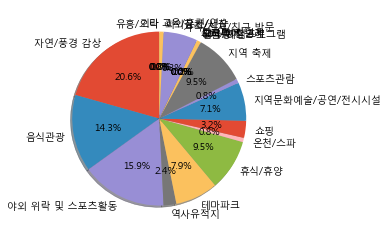

In [50]:
plt.pie(dicDF.loc[0], labels=dicDF.columns,  autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()